In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

In [3]:
plotsize_subplots = (cm2inch(20),cm2inch(3))
#plotsize_subplots = (16,3)

plotsize_mem_conn_subplots = (cm2inch(20),cm2inch(5))

fontsize_axis = 10
fontsize_labels = 8

#print(plt.rcParams.keys())

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels})

# Functions

In [2]:
def cm2inch(value):
    return value/2.54

In [122]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['T_conn']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    
    if 'NUM_VPS' not in list(df):
        df['NUM_VPS'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i kB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    # --> minne [kB] = 1000 * minne [B] = 1000 / 1024**2 * minne [MiB] 
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['NUM_VPS'])*1000/1024**2
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['NUM_VPS'])*1000/1024**2
    df['other'] = (df['VSize_sum']/df['NUM_VPS'])*1000/1024**2 - df['connections'] - df['ini']
    df['memory_per_rank'] = (df['VSize_sum']/df['NUM_VPS'])*1000/1024**2
    
    #print(df['connections'])
    #print(df['ini'])
    #print(df['other'])
    #print(df['connections'] + df['ini'] + df['other'])
    #print(df['memory_per_rank'])
    
    #print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])
    
    return df

In [54]:
def plot_results(df, name, df_err=None, plot_T_sim=True):
    ncols = 4
    values = ['T_conns_min', 'T_ini_min', 'T_conn']
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=['NUM_VPS'], values=values)
    df_mem = pd.pivot_table(df, index=['NUM_VPS'], values=['connections', 'ini', 'other'])
    
    if df_err is not None:
        df_err_p = pd.pivot_table(df_err, index=['NUM_VPS'], values=values)
        df_err_mem_p = pd.pivot_table(df_err, index=['NUM_VPS'], values=['connections', 'ini', 'other'])
        print(df_err_p)
    else:
        df_err_p = None
        df_err_mem_p = None
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', yerr=df_err_p, capsize=4, subplots=True, legend=False,
              ax=axes[:ncols-1], fontsize=fontsize_axis, rot=45)
    df_mem.plot(kind='bar', yerr=df_err_mem_p, capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=45, color=['purple', 'pink', 'red'])
    plt.legend(fontsize=6, loc='lower right')
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel('N_VP')
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['memory_per_rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [MiB]')
    axes[ncols-1].set_title('memory_per_rank')
    axes[ncols-1].set_xlabel('N_VP')

    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [6]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

In [115]:
def time_per_connection(df):
    df['time_per_connection'] = (df['T_conn']*df['NUM_VPS']/df['N_conns_sum'])*1e9
    return df

In [114]:
def memory_per_connection(df):
    """We use Connection memory + ini memory """
    df['memory_per_connection'] = ((df['VSize_ini_sum']-df['VSize_nodes_sum'])/df['N_conns_sum'])*1000
    return df

In [174]:
def plot_conn_and_mem(df, name):
    """Plot time per connection and memory per connection for different rules"""
    
    df_p = pd.pivot_table(df, index=['NUM_VPS', 'rule'], values=['time_per_connection', 'memory_per_connection'])
    
    print(df['NUM_VPS'].sort_values(ascending=True))
    # Make subplots
    axes = df_p.plot(kind='bar', subplots=True, legend=False, layout=(1,2),
                     x=df['NUM_VPS'].sort_values(ascending=True),
                     fontsize=fontsize_axis, rot=45, figsize = plotsize_mem_conn_subplots)
    
    
    color = plt.cm.Dark2(np.arange(len(df.rule.unique())))
    colors = [color[i] for i in range(len(df.rule.unique()))]*len(df)
    labels = list(df.rule.sort_values(ascending=True).unique())
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in range(len(labels))]
    
    for ax in axes.flat:
        ax.legend(handles=handles, labels=labels, fontsize=6, loc='upper right')
        for i,bar in enumerate(ax.patches):
            bar.set_color(colors[i])
    
    #plt.subplots_adjust(wspace=0.4)
    
    # x-axis labels
    for ax in axes[0]:#i, val_name in enumerate(list(df_p)):
        ax.set_xlabel('N_VP')
    
    # y-axes labels
    axes[0][0].set_ylabel('Memory [B]')
    axes[0][1].set_ylabel('Time [ns]')

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [61]:
def plot_fixed_VP_diff_threads(df, name):
    df_p = pd.pivot_table(df, index=['THREADS_PER_TASK'],
                               values=['T_conns_min', 'T_ini_min', 'T_conn', 'T_sim'])
    df_mem_p = pd.pivot_table(df, index=['THREADS_PER_TASK'], values=['connections', 'ini', 'other'])

    # Make subplots
    ncols = 5
    fig, axes = plt.subplots(nrows=1, ncols=ncols)

    df_p.plot(kind='bar', subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis, rot=45)
    df_mem_p.plot(kind='bar', stacked=True, legend=True, ax=axes[ncols-1],
                  fontsize=fontsize_axis, rot=45, color=['purple', 'pink', 'red'])
    plt.legend(fontsize=6, loc='lower right')

    plt.subplots_adjust(wspace=0.4)

    # x- and y-axes labels
    for ax in axes:
        ax.set_xlabel('Threads')

    axes[0].set_ylabel('Time [s]')
    axes[ncols-1].set_ylabel('Memory [MiB]')
    axes[ncols-1].set_title('memory_per_rank')

    fig.savefig(name, bbox_inches='tight')

    df_p['connections'] = df_mem_p['connections']
    df_p['ini']         = df_mem_p['ini']
    df_p['other']       = df_mem_p['other'] 
    
    return df_p

# FIG. 1

## HPC_benchmark

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,99.81,54.30,42.19,191.51,2743.245443,19.534429,55.615743
72,102.35,53.72,42.97,189.58,2743.245443,24.010340,53.295347
144,105.35,54.19,44.75,198.40,2743.245443,109.459559,53.315110
288,109.34,53.67,48.82,211.33,2743.245443,114.370373,53.326554
576,120.57,52.43,60.34,231.49,2743.245443,240.082449,53.680380
1152,139.73,52.39,79.09,267.39,2743.082682,576.399724,54.544893


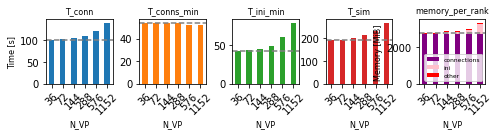

In [121]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf')

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
hpc_t6_s20_p

## HPC delay 0.1 - 50.

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,103.50,53.56,45.38,134.70,1930.745443,392.906825,51.058451
72,107.41,51.74,46.95,133.91,1930.745443,392.906825,53.295347
144,105.05,52.82,46.63,147.27,1930.745443,394.127528,53.315110
288,111.17,52.01,50.14,167.28,1930.745443,477.529552,53.326554
576,128.82,52.04,66.64,221.18,1951.578776,459.646251,53.680380
1152,147.11,52.05,85.56,353.64,1993.082682,460.134533,54.544893


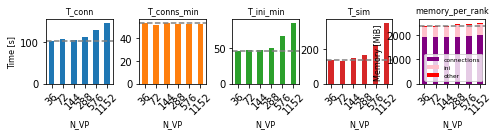

In [153]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_diff_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_diff_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,103.50,53.56,45.38,134.70,1930.745443,392.906825,51.058451
72,107.41,51.74,46.95,133.91,1930.745443,392.906825,53.295347
144,105.05,52.82,46.63,147.27,1930.745443,394.127528,53.315110
288,111.17,52.01,50.14,167.28,1930.745443,477.529552,53.326554
576,128.82,52.04,66.64,221.18,1951.578776,459.646251,53.680380
1152,147.11,52.05,85.56,353.64,1993.082682,460.134533,54.544893


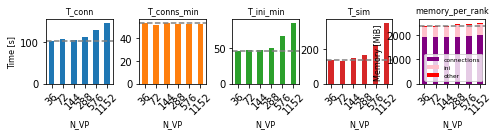

In [154]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_static_delays.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static_diff_delays.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_diff_delays_table.txt')
hpc_static_t6_s20_p

## HPC Split into many Connect calls

,T_conn,T_conns_min,T_ini_min,connections,ini,other
NUM_VPS,,,,,,
36,140.69,93.72,43.75,2743.245443,18.720627,58.382670
72,141.95,95.04,44.08,2743.245443,38.740158,127.676858
144,149.15,97.74,45.64,2743.245443,103.274663,231.605583
288,160.06,102.46,48.82,2743.245443,104.299572,458.369414
576,178.35,112.52,57.72,2743.245443,181.956636,399.135974
1152,219.40,133.32,77.62,2743.082682,553.613265,257.281641


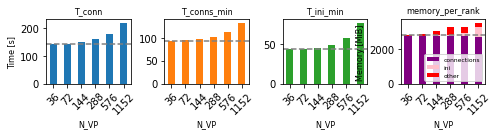

In [155]:
hpc_split_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split.csv')

hpc_split_t6_s20 = calculate_T_conn_and_memory(hpc_split_t6_s20)
hpc_split_t6_s20_p = plot_results(hpc_split_t6_s20, 'benchmark_figures/hpc_benchmark_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_table.txt')
hpc_split_t6_s20_p

## HPC split into many Connect calls, increasing number of NBLOCKS

,T_conn,T_conns_min,T_ini_min,connections,ini,other
NUM_VPS,,,,,,
36,141.45,93.72,43.51,2743.245443,16.279221,57.568868
72,289.88,231.57,43.54,2743.245443,40.367762,125.398212
144,847.58,753.47,42.66,2826.578776,19.127528,214.502176
288,3124.88,2744.99,44.27,2933.349609,116.689708,336.834855
576,NaN,NaN,NaN,NaN,NaN,NaN
1152,NaN,NaN,NaN,NaN,NaN,NaN


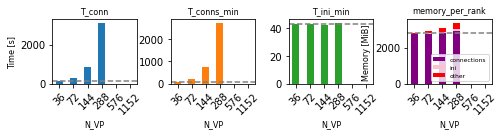

In [156]:
hpc_split_increase_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split_increase.csv')

hpc_split_increase_t6_s20 = calculate_T_conn_and_memory(hpc_split_increase_t6_s20)
hpc_split_increase_t6_s20_p = plot_results(hpc_split_increase_t6_s20,
                                           'benchmark_figures/hpc_benchmark_split_increase.pdf', plot_T_sim=False)

save_table_latex(hpc_split_increase_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_increase_table.txt')
hpc_split_increase_t6_s20_p

### HPC many connections per neuron
For comparison with population model

Important:
- N_nrns ~ 500 000 * NUMBER_OF_NODES
- N_conns_sum ~ 2 500 000 000 * NUMBER_OF_NODES

0    2.498000e+09
1             NaN
2    9.991999e+09
3    1.998400e+10
4    3.996799e+10
5    7.993598e+10
Name: N_conns_sum, dtype: float64
0      499500.0
1           NaN
2     1998000.0
3     3996000.0
4     7992000.0
5    15984000.0
Name: N_nrns, dtype: float64


,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,107.74,54.05,49.66,454.35,2722.900391,62.524901,67.822774
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,112.29,52.60,51.86,486.50,2722.900391,182.067447,70.242193
288,123.33,52.89,63.19,521.18,2722.900391,301.850028,70.253637
576,149.27,52.66,89.55,601.68,2722.900391,658.135970,70.607464
1152,212.94,51.89,152.67,703.80,2722.900391,771.852944,71.309215


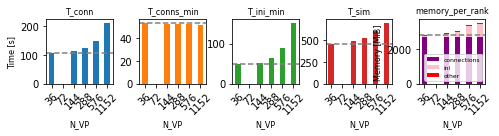

In [162]:
hpc_pop_comp = pd.read_csv('benchmark_results/hpc_pop_comp_benchmark_conn_sort_update_daint_t6_s44.csv')

hpc_pop_comp = calculate_T_conn_and_memory(hpc_pop_comp)

hpc_pop_comp_p = plot_results(hpc_pop_comp, 'benchmark_figures/hpc_benchmark_many_neurons.pdf')

save_table_latex(hpc_pop_comp_p.to_latex(), 'latex_tables/hpc_benchmark_many_neurons_table.txt')

print(hpc_pop_comp['N_conns_sum'])
print(hpc_pop_comp['N_nrns'])
hpc_pop_comp_p

## Population model

0     2500000000
1     5000000000
2    10000000000
3    20000000000
4    40000000000
5    80000000000
Name: N_conns_sum, dtype: int64
0      500000
1     1000000
2     2000000
3     4000000
4     8000000
5    16000000
Name: N_nrns, dtype: int64


,T_conn,T_conns_min,T_ini_min,connections,ini,other
NUM_VPS,,,,,,
36,86.77,44.25,39.58,1982.666016,95.207320,62.288920
72,88.60,44.43,40.50,1978.108724,139.478207,68.432066
144,91.95,46.16,41.46,1978.108724,220.166948,68.451828
288,95.33,48.49,43.75,1978.108724,124.685314,68.463273
576,110.80,53.36,54.05,1978.108724,398.448335,68.817099
1152,172.28,64.57,96.74,1978.108724,443.953435,69.518851


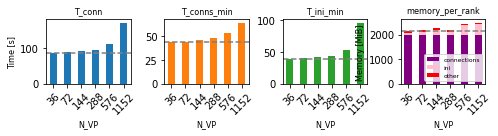

In [157]:
population = pd.read_csv('benchmark_results/population_model_conn_sort_update_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

print(population['N_conns_sum'])
print(population['N_nrns'])
population_p

## Multi-Area Model

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,157.306587,118.479932,38.826491,1141.184268,2551.994324,57.674620,-3.481659e-13
72,200.466683,162.750995,37.715194,1415.311204,2552.712123,96.167458,9.168837e+00
144,285.568365,245.596020,39.971991,1674.480795,2553.382927,181.331846,6.388346e+00
288,455.648637,411.628427,44.018951,2008.395862,2625.877460,247.731739,-1.989520e-13
576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1152,1527.222877,1463.018885,64.201841,3023.417031,2939.622925,456.360075,5.684342e-14


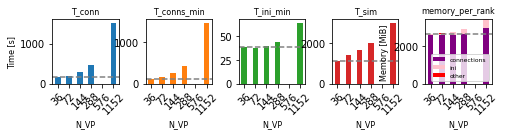

In [158]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_conn_sort_update_daint_t6_s0_0625.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=True)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')
MAM_t6_s0_0625_p

## 4x4 mesocircuit

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,NUM_VPS,hash,num_tasks,T_nrns,T_conns_avg,T_conns_min,...,N_spks_sum,N_nrns,N_conns_sum,T_bld_xn,T_bld_nx,T_conn,connections,ini,other,memory_per_rank
0,1,6,6,0.0625,36,acd429db3b9ab17b5f5391184e500dc6,6,0.55,169.435000,169.10,...,560690,77169,345443323,175.15,175.65,175.15,502.441406,112.575955,49.678167,664.695528
1,2,6,6,0.1250,72,acd429db3b9ab17b5f5391184e500dc6,12,0.94,193.399167,193.27,...,1231702,154338,690927633,199.94,200.46,199.94,521.647135,103.027344,63.959334,688.633813
2,4,6,6,0.2500,144,acd429db3b9ab17b5f5391184e500dc6,24,2.18,227.260833,226.92,...,2725785,308676,1381963143,234.20,234.88,234.20,540.201823,123.833550,75.697846,739.733219
3,8,6,6,0.5000,288,acd429db3b9ab17b5f5391184e500dc6,48,3.88,330.619792,330.18,...,5629041,617352,2763938640,338.22,339.09,338.22,455.751313,173.928923,103.053040,732.733276
4,16,6,6,1.0000,576,acd429db3b9ab17b5f5391184e500dc6,96,7.97,519.575833,519.27,...,10859878,1234704,5527888387,529.73,530.76,529.73,409.618908,233.214405,171.115200,813.948512
5,32,6,6,2.0000,1152,acd429db3b9ab17b5f5391184e500dc6,192,21.36,927.114583,926.42,...,21690611,2469408,11055874121,940.37,942.03,940.37,410.834524,363.298972,303.652889,1077.786386


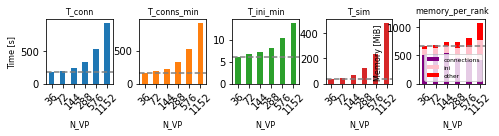

In [160]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_conn_sort_update_daint_t6_s0_0625.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=True)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')
meso_t6_s0_0625

# FIG. 2
Compare different connection rules

In [175]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s1_in.csv')
hpc_in['rule'] = ['indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s1_out.csv')
hpc_out['rule'] = ['outdegree']*len(hpc_out)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s1_bern.csv')
hpc_bern['rule'] = ['bernoulli']*len(hpc_bern)

hpc_rules = pd.concat([hpc_in, hpc_out, hpc_bern])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_per_connection(hpc_rules)
hpc_rules = memory_per_connection(hpc_rules)

hpc_rules_p = plot_conn_and_mem(hpc_rules, 'benchmark_figures/hpc_rules.pdf')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_table.txt')

hpc_rules_p

0                                                                                                                                                                                                                                                                                                 36.0
0                                                                                                                                                                                                                                                                                                 36.0
1                                                                                                                                                                                                                                                                                                 72.0
1                                                                                                                  

ValueError: Length mismatch: Expected axis has 12 elements, new values have 13 elements

# FIG. 3
Compare hpc with few neurons per node and hpc with many neurons per node

0      36
0      36
1      72
1      72
2     144
2     144
3     288
3     288
4     576
4     576
5    1152
5    1152
Name: NUM_VPS, dtype: int64


memory_per_connection  time_per_connection
NUM_VPS rule                                                    
36      few neurons               41.197881          1419.393271
        many neurons              42.092179          1552.697848
72      few neurons               41.264633          1455.514778
        many neurons                    NaN                  NaN
144     few neurons               42.538835          1498.177792
        many neurons              43.898669          1618.270778
288     few neurons               42.612066          1554.919486
        many neurons              45.708776          1777.374166
576     few neurons               44.486655          1714.620880
        many neurons              51.092823          2151.209344
1152    few neurons               49.499309          1987.094456
        many neurons              52.811267          3068.791609

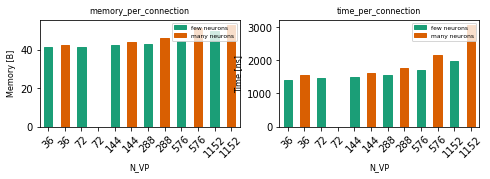

In [177]:
hpc_t6_s20['rule']  = ['few neurons']*len(hpc_t6_s20)
hpc_pop_comp['rule'] = ['many neurons']*len(hpc_pop_comp)
#population['rule'] = ['population']*len(population)

hpc_few_many = pd.concat([hpc_t6_s20, hpc_pop_comp])#, population])

hpc_few_many = time_per_connection(hpc_few_many)
hpc_few_many = memory_per_connection(hpc_few_many)

hpc_few_many_p = plot_conn_and_mem(hpc_few_many, 'benchmark_figures/hpc_few_many.pdf')
save_table_latex(hpc_few_many_p.to_latex(), 'latex_tables/hpc_few_many_table.txt')

hpc_few_many_p

# FIG. 4
Compare nblocks and population

['NBLOCKS', 'increasing NBLOCKS', 'population']


memory_per_connection  time_per_connection
NUM_VPS rule                                                          
36      NBLOCKS                         41.365902          2009.497507
        increasing NBLOCKS              41.329337          2020.352707
        population                      31.374837          1249.488000
72      NBLOCKS                         41.665742          2027.494688
        increasing NBLOCKS              41.690118          4140.402678
        population                      31.974492          1275.840000
144     NBLOCKS                         42.632278          2130.333658
        increasing NBLOCKS              44.198319         12554.414558
        population                      33.192851          1324.080000
288     NBLOCKS                         42.647630          2286.163072
        increasing NBLOCKS              49.193584         48065.830926
        population                      31.751127          1372.752000
576     NBLOCKS                         43.810700          2547.402186
        increasing NBLOCKS                    NaN                  NaN
        population                      35.884810          1595.520000
1152    NBLOCKS                         49.374558          3133.726081
        increasing NBLOCKS                    NaN                  NaN
        population                      36.571914          2480.832000

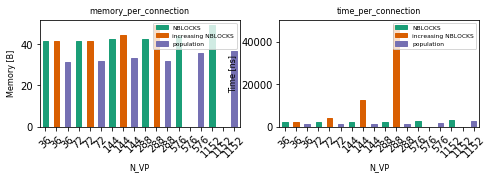

In [148]:
hpc_split_t6_s20['rule']          = ['NBLOCKS']*len(hpc_split_t6_s20)
hpc_split_increase_t6_s20['rule'] = ['increasing NBLOCKS']*len(hpc_split_increase_t6_s20)
population['rule']                = ['population']*len(population)

increasing_conns = pd.concat([hpc_split_t6_s20, hpc_split_increase_t6_s20, population])

increasing_conns = time_per_connection(increasing_conns)
increasing_conns = memory_per_connection(increasing_conns)

increasing_conns_p = plot_conn_and_mem(increasing_conns, 'benchmark_figures/increasing_conns.pdf')
save_table_latex(increasing_conns_p.to_latex(), 'latex_tables/increasing_conns_table.txt')

increasing_conns_p

# FIG. 5
Comapare hpc, MAM and 4x4

['4x4', 'MAM', 'hpc']


memory_per_connection  time_per_connection
NUM_VPS rule                                            
36      4x4               67.206764         18253.066654
        MAM               65.307900          3754.285504
        hpc               41.197881          1419.393271
72      4x4               68.258008         20835.293470
        MAM               66.289063          4784.339126
        hpc               41.264633          1455.514778
144     4x4               72.553298         24403.545182
        MAM               68.437067          6815.371506
        hpc               42.538835          1498.177792
288     4x4               68.799307         35242.229545
        MAM               71.912916         10874.501463
        hpc               42.612066          1554.919486
576     4x4               70.236281         55197.293910
        MAM                     NaN                  NaN
        hpc               44.486655          1714.620880
1152    4x4               84.581458         97984.675670
        MAM               84.985451         36448.661236
        hpc               49.499309          1987.094456

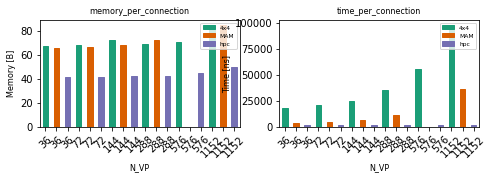

In [149]:
hpc_t6_s20['rule']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['rule']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['rule'] = ['4x4']*len(meso_t6_s0_0625)

hpc_MAM_4x4 = pd.concat([hpc_t6_s20, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_MAM_4x4 = time_per_connection(hpc_MAM_4x4)
hpc_MAM_4x4 = memory_per_connection(hpc_MAM_4x4)
hpc_MAM_4x4_p = plot_conn_and_mem(hpc_MAM_4x4, 'benchmark_figures/hpc_MAM_4x4.pdf')
save_table_latex(hpc_MAM_4x4_p.to_latex(), 'latex_tables/hpc_MAM_4x4_table.txt')

hpc_MAM_4x4_p



# FIG. 6
Fixed VP, different threads

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
THREADS_PER_TASK,,,,,,,
1,NaN,22.19,NaN,NaN,2.716797,NaN,NaN
3,100.70,38.16,49.48,271.22,2.739258,0.685848,0.101684
6,145.46,52.58,85.38,280.44,2.743083,0.590325,0.054557
9,203.68,56.10,142.77,276.90,2.742622,0.566051,0.043944
18,506.47,74.29,426.64,295.89,2.751028,0.518179,0.032272
36,1545.11,109.58,1430.94,392.68,2.759644,0.515601,0.027414


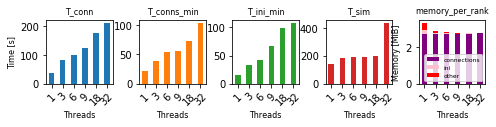

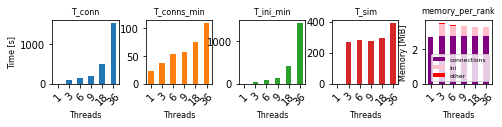

In [109]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_s20_threads.csv')
hpc_threads_n36 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_threads_n36.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)
hpc_threads_n36 = calculate_T_conn_and_memory(hpc_threads_n36)

hpc_threads_n1_p = plot_fixed_VP_diff_threads(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf')
hpc_threads_n36_p = plot_fixed_VP_diff_threads(hpc_threads_n36, 'benchmark_figures/hpc_fixedVP_diff_threads_n36.pdf')

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
save_table_latex(hpc_threads_n36_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n36_table.txt')
#hpc_threads_n1_p
hpc_threads_n36_p